In [100]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

# Helper Functions

In [43]:
def missing_values(data,n):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(
        ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(n)

def test_train(train, test):
    train['source']= 'train'
    test['source'] = 'test'
    data=pd.concat([train, test],ignore_index=True)
    print(data.shape)
    return data

def get_column_type(data):
    obj = []
    int_cont = []
    for name in data.columns:
        if data[name].dtype is np.dtype( 'O') and name != 'source':
            obj.append(name)
        else:
            int_cont.append(name)
    return obj, int_cont

def dummy_data(data, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(data[x], prefix=x, dummy_na=False)
        data = data.drop(x,1)
        data = pd.concat([data, dummies], axis=1)
    return data

zoneToStateMapping = {'SW':['lagos', 'oyo', 'ekiti', 'ogun', 'ondo', 'osun'],
                      'SS':['akwa ibom', 'bayelsa', 'cross river', 'rivers', 'delta', 'edo'],
                     'SE':['abia','anambra','ebonyi', 'enugu', 'imo'],
                     'NW':['jigawa','kaduna','kano','katsina','kebbi','sokoto','zamfara'],
                     'NE':['adamawa','bauchi','borno','gombe','yobe','taraba'],
                     'NC':['benue','kogi','kwara','nassarawa','niger','plateau','fct']}

def groupByZone(state):
    state = state.lower()
    for zone in zoneToStateMapping:
        if state in zoneToStateMapping[zone]:
            return zone
        else:continue

def plot_correlation_matrix(data, columns):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(data[columns].astype(float).corr(),linewidths=0.1,vmax=1.0,
                square=True, cmap=colormap, linecolor='white', annot=True)

# Get data

In [54]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['Promoted_or_Not'] = train['Promoted_or_Not'].astype(int)
data = test_train(train, test)

(54808, 20)


In [55]:
data.head(2)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,Previous_IntraDepartmental_Movement,Promoted_or_Not,Qualification,State_Of_Origin,Targets_met,Training_score_average,Trainings_Attended,Year_of_birth,Year_of_recruitment,source
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,No,0.0,"MSc, MBA and PhD",ANAMBRA,1,41,2,1986,2011,train
1,Agency and others,Customer Support and Field Operations,YAK/S/00002,Yes,Male,12.5,Married,0,No,0,No,0.0,First Degree or HND,ANAMBRA,0,52,2,1991,2015,train


In [56]:
missing_values(data,3)

,Total,Percent
Promoted_or_Not,16496,30.097796
Qualification,2409,4.395344
source,0,0.000000


In [57]:
data['Age'] = 2019 - data.Year_of_birth
data['Age_recurited'] = data.Year_of_recruitment - data.Year_of_birth
data['Years_in_company'] = 2019 - data.Year_of_recruitment
data['Qualification'] = data['Qualification'].fillna(value='something_here')
data['zone'] = data.State_Of_Origin.apply(lambda x: groupByZone(x))
data.drop(['Year_of_recruitment','Year_of_birth','State_Of_Origin'], 1,inplace=True)
data['Targets_met'] = data['Targets_met'].astype(str)
data['Previous_Award'] = data['Previous_Award'].astype(str)

In [58]:
data.head(1)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,...,Promoted_or_Not,Qualification,Targets_met,Training_score_average,Trainings_Attended,source,Age,Age_recurited,Years_in_company,zone
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,...,0.0,"MSc, MBA and PhD",1,41,2,train,33,25,8,SE


In [59]:
categorical, continous = get_column_type(data)

In [60]:
categorical

['Channel_of_Recruitment',
 'Division',
 'EmployeeNo',
 'Foreign_schooled',
 'Gender',
 'Marital_Status',
 'No_of_previous_employers',
 'Past_Disciplinary_Action',
 'Previous_Award',
 'Previous_IntraDepartmental_Movement',
 'Qualification',
 'Targets_met',
 'zone']

In [61]:
continous_corr = [i for i in continous if i not in ['source']]

In [62]:
for c in ['Age', 'Age_recurited', 'Years_in_company', 'Training_score_average']:
    data[c] = np.log1p(data[c])

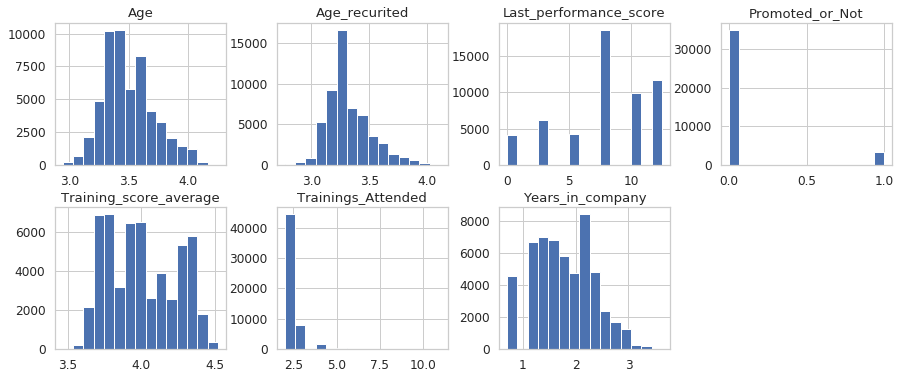

In [63]:

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

data[continous].hist(bins=15, figsize=(15, 6), layout=(2, 4));

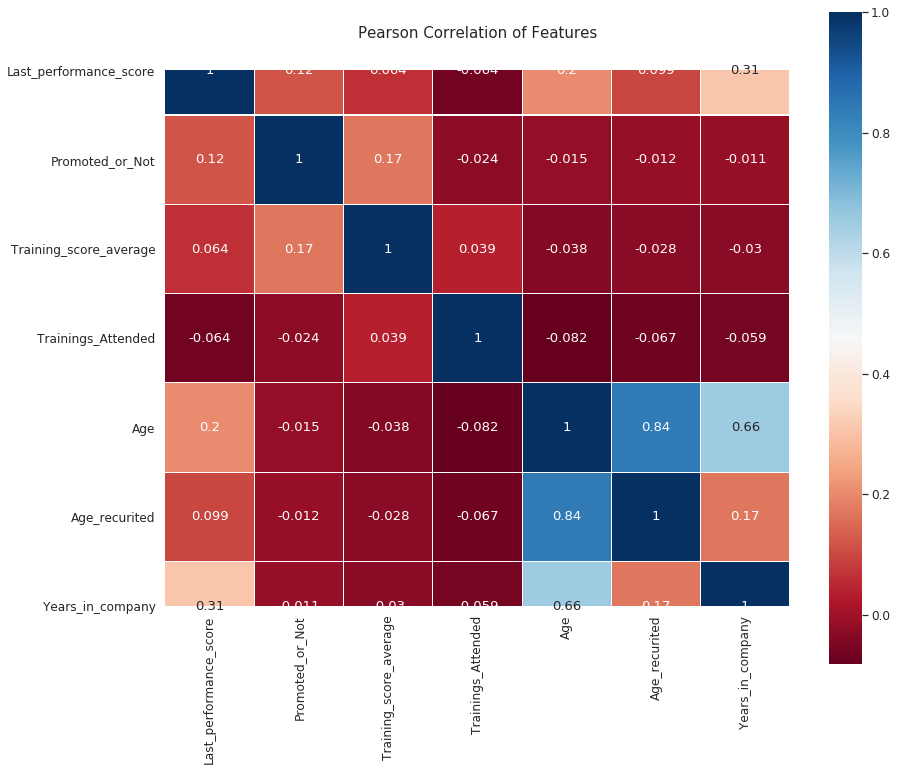

In [64]:
plot_correlation_matrix(data, continous_corr)

What affects promotion most is the Last Performance Score and Training Score average,
this can be seen in the correlation matrix above.

In [66]:
data.head(1)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,...,Promoted_or_Not,Qualification,Targets_met,Training_score_average,Trainings_Attended,source,Age,Age_recurited,Years_in_company,zone
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,...,0.0,"MSc, MBA and PhD",1,3.73767,2,train,3.526361,3.258097,2.197225,SE


In [70]:
to_dummy = [ i for i in categorical if i not in ['EmployeeNo']]
data = dummy_data(data, to_dummy)

In [71]:
data.shape

(54808, 53)

In [72]:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']
train.drop('source',axis=1,inplace=True)
test.drop(['source','Promoted_or_Not'],axis=1,inplace=True)

# Data Splitting

In [83]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Promoted_or_Not'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Promoted_or_Not'], cv=cv_folds, scoring='f1')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Promoted_or_Not'].values, dtrain_predictions))
    print("F1-Score (Train): %f" % metrics.f1_score(dtrain['Promoted_or_Not'], dtrain_predictions))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),
                                                                                 np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.941
F1-Score (Train): 0.468846
CV Score : Mean - 0.4605622 | Std - 0.01927901 | Min - 0.4359281 | Max - 0.4942263


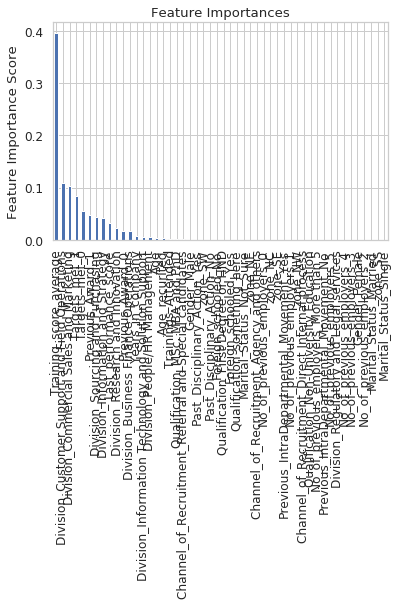

In [84]:
IDcol = 'EmployeeNo'
target = 'Promoted_or_Not'
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
predictors = ['Training_score_average','Age', 'Age_recurited', 'Years_in_company', 
      'Last_performance_score','Targets_met_0','Previous_Award_1','Trainings_Attended']

Y = train['Promoted_or_Not']
X = train[predictors]
# X = preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

clfs = [KNeighborsClassifier(n_neighbors = 1), 
      GaussianNB(),
      DecisionTreeClassifier(splitter = 'random'),
       RandomForestClassifier()]
clfName = {1:'KNN', 2:'Naive Bayes', 3:'Decision Trees', 4:'Random Forests'}

for i in range(len(clfs)):
    scores = cross_val_score(clfs[i], X_train, Y_train.ravel(), cv=5, scoring = 'f1')
    print ("mean validation F1 for",clfName[i+1], ":", 
           "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    clf = clfs[i].fit(X_train, Y_train.ravel())
    Y_pred = clf.predict(X_test)
    f1 = f1_score(Y_test, Y_pred)
    print ('Test F1 for',clfName[i+1], ":", f1)

mean validation F1 for KNN : Accuracy: 0.25 (+/- 0.02)
Test F1 for KNN : 0.229045643153527
mean validation F1 for Naive Bayes : Accuracy: 0.20 (+/- 0.04)
Test F1 for Naive Bayes : 0.17179487179487182
mean validation F1 for Decision Trees : Accuracy: 0.28 (+/- 0.03)
Test F1 for Decision Trees : 0.2577405857740586
mean validation F1 for Random Forests : Accuracy: 0.28 (+/- 0.02)
Test F1 for Random Forests : 0.27868852459016397


Text(0, 0.5, 'Feature Importance Score')

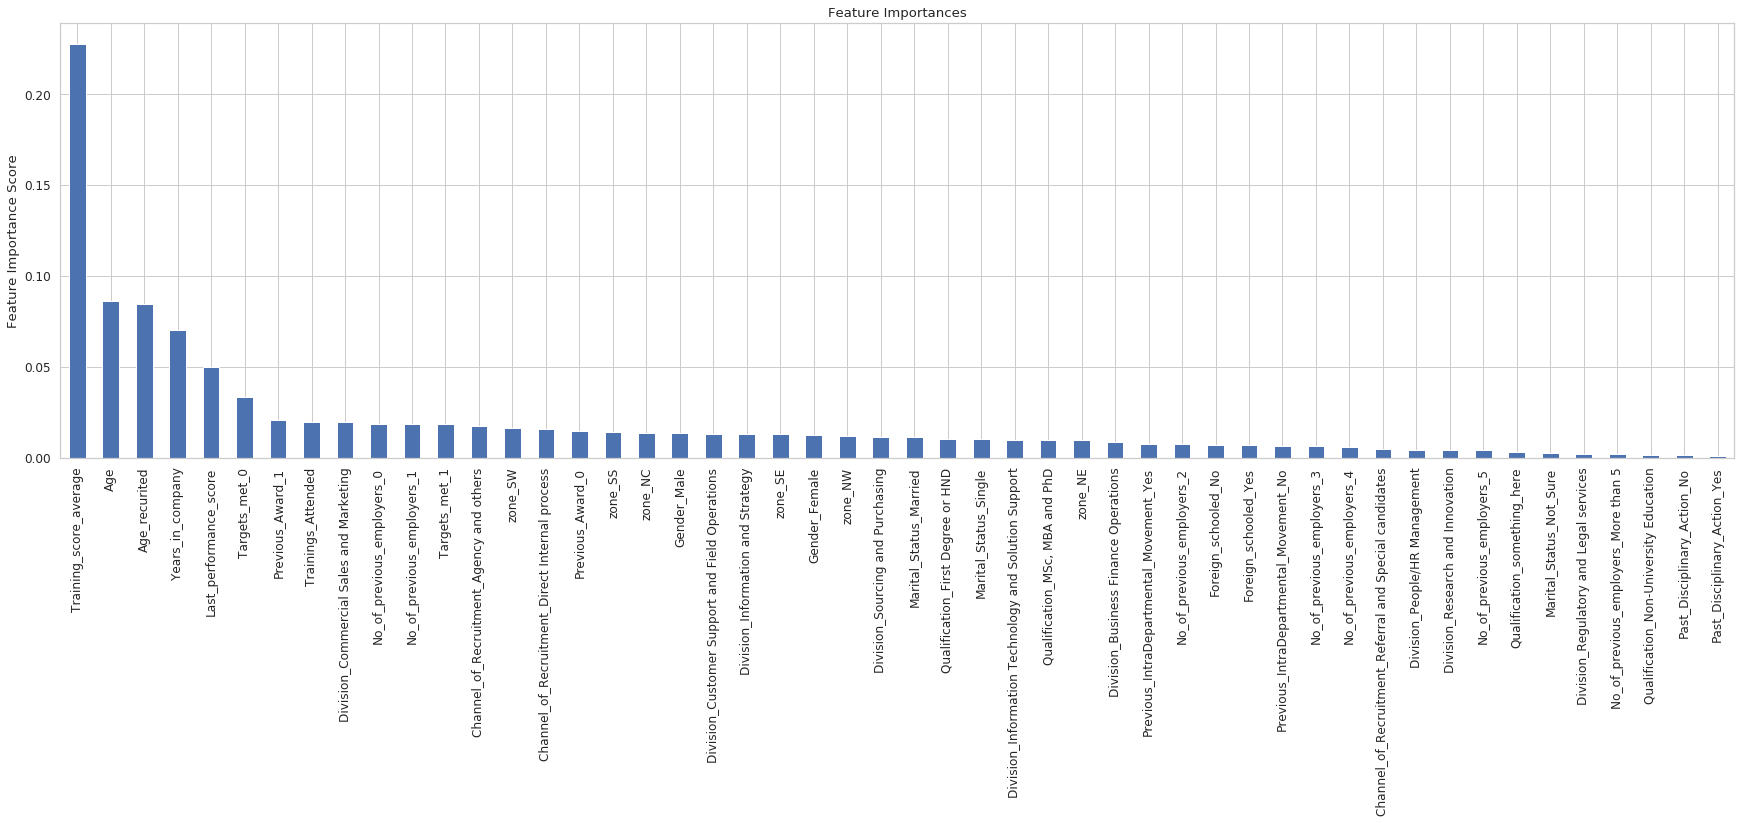

In [104]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8
feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')